#### **Import Libraries**

In [1]:
import jax 
import jax.numpy as jnp

#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/Users/ppower1/Documents/GitHub/rfp/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-LightItalic.ttf


In [2]:
# Data Hyperparameters
min_obs_per_cluster  = 10 
max_obs_per_cluster = 50 
n_clusters =  6
key_num = 18
key = jax.random.PRNGKey(key_num)

In [9]:
def main_effect(x, p1, p2, p3):
  return jnp.log(x**2 + p3 + jnp.sin(x*p1)) + p2


fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Outcome', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

key = jax.random.PRNGKey(0)
for i in range(1, 7):
    key, k1, k2, k3 = jax.random.split(key, 4)
    p1 = jax.random.uniform(k1, shape=(1,)) * 2.0
    p2 = jax.random.uniform(k2, shape=(1,)) * 2.0
    p3 = jax.random.uniform(k3, shape=(1,)) * 2.0
    ys = main_effect(xs, p1, p2, p3)
plt.plot(xs, ys)
plt.xlabel('Feature', size=14)
plt.show()

TypeError: main_effect() missing 3 required positional arguments: 'p1', 'p2', and 'p3'

In [3]:


def gen_functions(key, x, i):
  key, subkey = jax.random.split(key)
  weights = random.normal(subkey, shape=(4,))
  y = main_effect(x) #weights[0] + weights[1]*x + weights[2] * jnp.sin(x)
  y = y - jnp.mean(y) # Normalize within Cluster
  plt.scatter(x, y, label=i+1)
  return y 

def gen_samples(key, min_obs, max_obs, n_cohorts, eps):
  d = {}
  fig = plt.figure(dpi=300, tight_layout=True, figsize=(6.4, 4.8))
  for i in range(n_cohorts):
    key, subkey = jax.random.split(key)
    n_obs = jax.random.choice(subkey, max_obs-min_obs ) + min_obs
    x_mean = random.normal(key, shape=(1,))
    x = jnp.linspace(x_mean - eps, x_mean + eps, n_obs) 
    y = gen_functions(key, x, i)
    d[i] = jnp.hstack((x, y))
  plt.legend(title=r'$E[Y|C=i]$', ncol=2, fontsize='xx-small')
  plt.title(r'$Y$', loc='left')
  plt.xlabel(r'$X$')
  fig.savefig('motivating_cefs.pdf', format='pdf')
  plt.show()
  return d

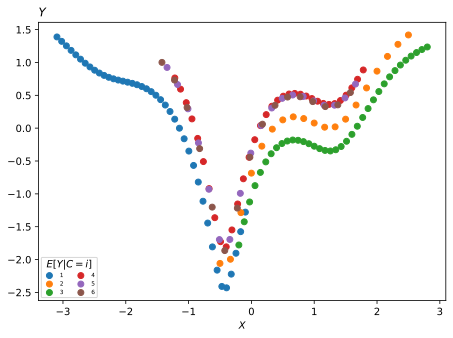

In [4]:
data = gen_samples(key, min_obs, max_obs, n_cohorts, eps)


In [5]:
data_matrix = jnp.vstack((i for i in data.values()))
data_matrix = jnp.hstack((jnp.ones((data_matrix.shape[0], 1)), data_matrix))

In [6]:
def weight(xi, x, tau):
  return jnp.exp( - (xi -x)**2/2*tau**2)

def weight_matrix(x, tau):
  return vmap(weight, in_axes=(0, None, None))(data_matrix[:,1], x, tau)

def params(X, W, Y):
  return jnp.matmul(jnp.linalg.inv(jnp.matmul(X.T, jnp.matmul(jnp.diag(W.reshape(-1,)),X))),jnp.matmul(X.T, jnp.matmul(jnp.diag(W.reshape(-1,)),Y)))

def predict(weights, inputs):
  return jnp.dot(weights, inputs)

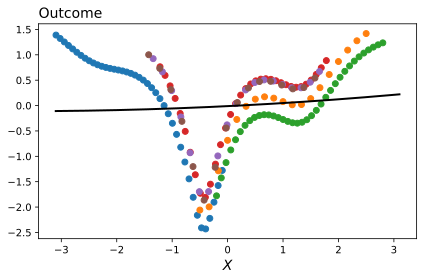

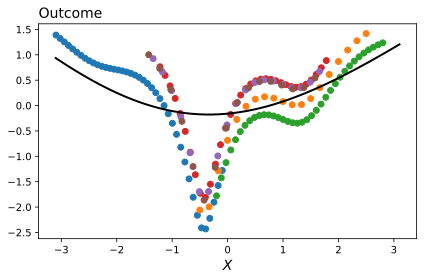

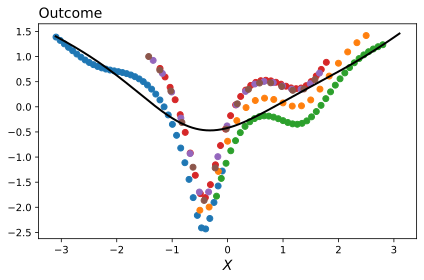

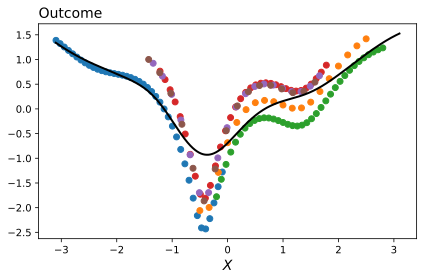

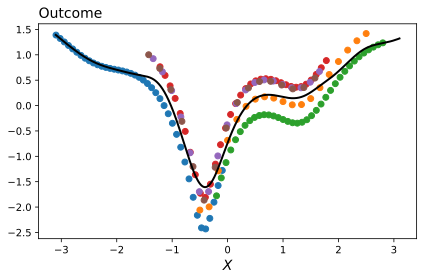

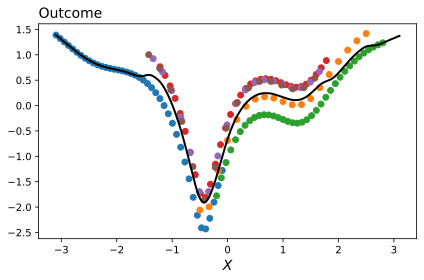

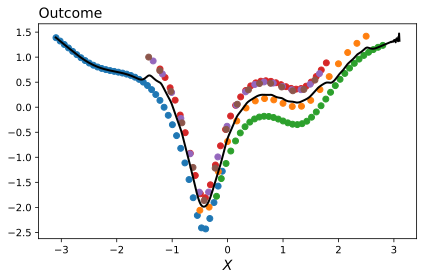

In [7]:
for bw in [0.1, 0.5, 1., 2., 5., 10., 15.]:
  inputs = jnp.linspace(-3.1,3.1,1000).reshape(-1,1)
  weights = vmap(weight_matrix, in_axes=(0, None))(inputs, bw)
  local_linear_thetas = vmap(params, in_axes=(None, 0, None))(data_matrix[:,:2], weights, data_matrix[:, -1].reshape(-1,1))
  intercept_inputs = jnp.hstack((jnp.ones_like(inputs), inputs))
  yhat = vmap(predict, in_axes=(0,0))(intercept_inputs, local_linear_thetas)
  fig = plt.figure(dpi=300, tight_layout=True)
  plt.plot(inputs, yhat, color='black', linewidth=2)
  for i in range(len(data)):
    plt.scatter(data[i][:,0], data[i][:, 1])
  plt.title('Outcome', loc='left', size=14)
  plt.xlabel(r'$X$', size=14)
  fig.savefig(f'local_linear_no_const_{bw}_{key_num}_LM.pdf', format='pdf')
  fig.savefig(f'local_linear_no_const_{bw}_{key_num}_LM.png', format='png')
  plt.show()